<a href="https://colab.research.google.com/github/Shah-zam9/DVLM_Assignment0/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Device: cuda
Preparing Data...


100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]



--- 1. Baseline: Pretrained + Frozen Backbone ---
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 190MB/s]


Training Baseline (Transfer)...
  Epoch 1/5 | Loss: 1.326 | Acc: 57.0%
  Epoch 2/5 | Loss: 0.708 | Acc: 78.4%
  Epoch 3/5 | Loss: 0.589 | Acc: 81.3%
  Epoch 4/5 | Loss: 0.527 | Acc: 83.2%
  Epoch 5/5 | Loss: 0.467 | Acc: 85.0%

--- 2. Random Init: No Pretraining ---
Training Random Init...
  Epoch 1/5 | Loss: 2.597 | Acc: 11.0%
  Epoch 2/5 | Loss: 2.485 | Acc: 11.7%
  Epoch 3/5 | Loss: 2.500 | Acc: 11.6%
  Epoch 4/5 | Loss: 2.469 | Acc: 11.9%
  Epoch 5/5 | Loss: 2.464 | Acc: 13.2%

--- 3. Fine-Tuning: Unfreezing Layer 4 ---
Training Fine-Tuning (Layer 4)...
  Epoch 1/3 | Loss: 0.457 | Acc: 85.5%
  Epoch 2/3 | Loss: 0.083 | Acc: 98.2%
  Epoch 3/3 | Loss: 0.032 | Acc: 99.5%


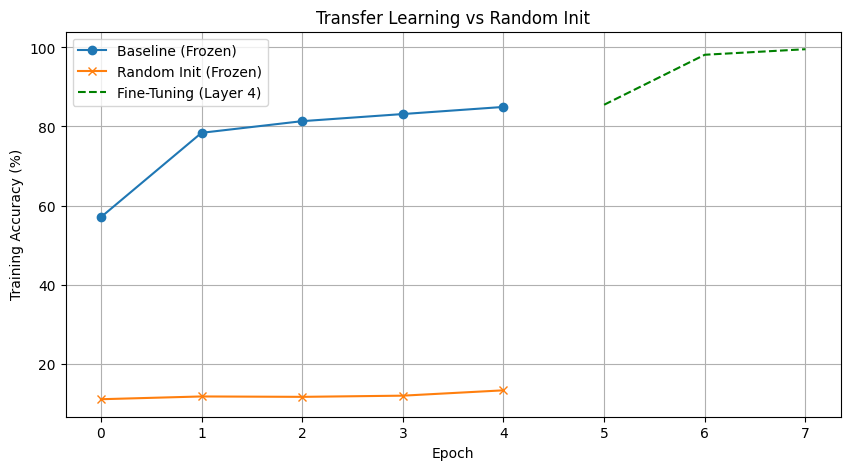


--- 4. Extracting Feature Hierarchies ---
Running UMAP (This may take a moment)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


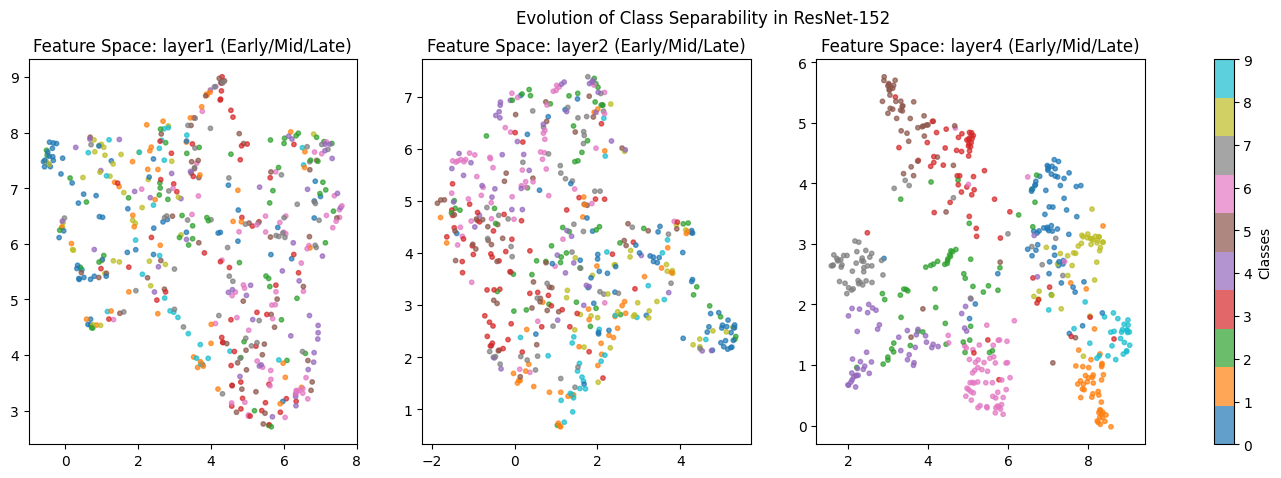

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import umap
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("Preparing Data...")
train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_full = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_indices = np.random.choice(len(train_full), 2000, replace=False)
test_indices = np.random.choice(len(test_full), 500, replace=False)

train_loader = DataLoader(Subset(train_full, train_indices), batch_size=32, shuffle=True)
test_loader = DataLoader(Subset(test_full, test_indices), batch_size=32, shuffle=False)

def train_model(model, epochs=5, lr=0.001, name="Model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    history = []

    print(f"Training {name}...")
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_acc = 100. * correct / total
        history.append(epoch_acc)
        print(f"  Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.3f} | Acc: {epoch_acc:.1f}%")
    return history

print("\n--- 1. Baseline: Pretrained + Frozen Backbone ---")
model_baseline = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

for param in model_baseline.parameters():
    param.requires_grad = False

model_baseline.fc = nn.Linear(2048, 10)
model_baseline = model_baseline.to(device)

acc_baseline = train_model(model_baseline, epochs=5, name="Baseline (Transfer)")

print("\n--- 2. Random Init: No Pretraining ---")
model_random = models.resnet152(weights=None)

for param in model_random.parameters():
    param.requires_grad = False

model_random.fc = nn.Linear(2048, 10)
model_random = model_random.to(device)

acc_random = train_model(model_random, epochs=5, name="Random Init")

print("\n--- 3. Fine-Tuning: Unfreezing Layer 4 ---")
for param in model_baseline.layer4.parameters():
    param.requires_grad = True

acc_finetune = train_model(model_baseline, epochs=3, lr=0.0001, name="Fine-Tuning (Layer 4)")
acc_total_finetune = acc_baseline + acc_finetune

plt.figure(figsize=(10, 5))
plt.plot(acc_baseline, label='Baseline (Frozen)', marker='o')
plt.plot(acc_random, label='Random Init (Frozen)', marker='x')
plt.plot(range(len(acc_baseline), len(acc_baseline)+len(acc_finetune)), acc_finetune, label='Fine-Tuning (Layer 4)', linestyle='--', color='green')
plt.title("Transfer Learning vs Random Init")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig("resnet_task1_dynamics.png")
plt.show()

print("\n--- 4. Extracting Feature Hierarchies ---")
features = {'layer1': [], 'layer2': [], 'layer4': []}
labels_list = []

def get_hook(name):
    def hook(model, input, output):
        pooled = output.mean(dim=[2,3]).cpu().detach().numpy()
        features[name].append(pooled)
    return hook

h1 = model_baseline.layer1.register_forward_hook(get_hook('layer1'))
h2 = model_baseline.layer2.register_forward_hook(get_hook('layer2'))
h4 = model_baseline.layer4.register_forward_hook(get_hook('layer4'))

model_baseline.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        _ = model_baseline(inputs)
        labels_list.append(labels.numpy())

h1.remove(); h2.remove(); h4.remove()

labels_all = np.concatenate(labels_list)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

print("Running UMAP (This may take a moment)...")
for i, layer in enumerate(['layer1', 'layer2', 'layer4']):
    feats = np.concatenate(features[layer])

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(feats)

    sc = axes[i].scatter(embedding[:, 0], embedding[:, 1], c=labels_all, cmap='tab10', s=10, alpha=0.7)
    axes[i].set_title(f"Feature Space: {layer} (Early/Mid/Late)")

plt.colorbar(sc, ax=axes.ravel().tolist(), label='Classes')
plt.suptitle("Evolution of Class Separability in ResNet-152")
plt.savefig("resnet_feature_hierarchy.png")
plt.show()


--- 5. Residual Connections Experiment ---
Training Model with DISABLED Residuals (Layer 4)...
Training Broken Residuals...
  Epoch 1/5 | Loss: 1.867 | Acc: 40.5%
  Epoch 2/5 | Loss: 1.340 | Acc: 60.8%
  Epoch 3/5 | Loss: 1.174 | Acc: 66.5%
  Epoch 4/5 | Loss: 1.089 | Acc: 66.5%
  Epoch 5/5 | Loss: 1.012 | Acc: 69.0%


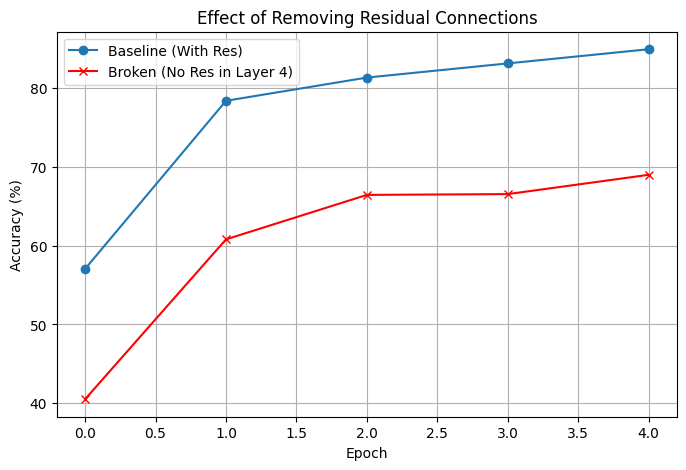

Task 1 Complete.


In [2]:
def broken_forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)


    out = self.relu(out)
    return out

print("\n--- 5. Residual Connections Experiment ---")

model_broken = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

import types
for block in model_broken.layer4:
    block.forward = types.MethodType(broken_forward, block)

for param in model_broken.parameters():
    param.requires_grad = False
model_broken.fc = nn.Linear(2048, 10)
model_broken = model_broken.to(device)

print("Training Model with DISABLED Residuals (Layer 4)...")
acc_broken = train_model(model_broken, epochs=5, name="Broken Residuals")

plt.figure(figsize=(8, 5))
plt.plot(acc_baseline, label='Baseline (With Res)', marker='o')
plt.plot(acc_broken, label='Broken (No Res in Layer 4)', marker='x', color='red')
plt.title("Effect of Removing Residual Connections")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.savefig("resnet_residuals_comparison.png")
plt.show()

print("Task 1 Complete.")